In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-new/GBvideos.csv
/kaggle/input/youtube-new/MXvideos.csv
/kaggle/input/youtube-new/KRvideos.csv
/kaggle/input/youtube-new/MX_category_id.json
/kaggle/input/youtube-new/GB_category_id.json
/kaggle/input/youtube-new/US_category_id.json
/kaggle/input/youtube-new/IN_category_id.json
/kaggle/input/youtube-new/DEvideos.csv
/kaggle/input/youtube-new/KR_category_id.json
/kaggle/input/youtube-new/RU_category_id.json
/kaggle/input/youtube-new/FRvideos.csv
/kaggle/input/youtube-new/USvideos.csv
/kaggle/input/youtube-new/INvideos.csv
/kaggle/input/youtube-new/RUvideos.csv
/kaggle/input/youtube-new/CA_category_id.json
/kaggle/input/youtube-new/DE_category_id.json
/kaggle/input/youtube-new/JP_category_id.json
/kaggle/input/youtube-new/JPvideos.csv
/kaggle/input/youtube-new/FR_category_id.json
/kaggle/input/youtube-new/CAvideos.csv


# 1: Introduction & Setup

In [2]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Visualization settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Color palette
colors = ['#FF0000', '#282828', '#065535', '#AAAAAA', '#3EA6FF']

print("✅ All libraries imported successfully!")
print("📁 Ready to explore YouTube trending data...")

✅ All libraries imported successfully!
📁 Ready to explore YouTube trending data...


# 2: Load Data & Initial Inspection

In [3]:
# List of country codes available
countries = ['CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX']

# Dictionary to store all dataframes
video_data = {}
category_data = {}

# Load CSV files with multiple encoding attempts
print("Loading video data from different countries...\n")
for country in countries:
    csv_file = f'/kaggle/input/youtube-new/{country}videos.csv'
    
    # Try multiple encodings
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    loaded = False
    
    for encoding in encodings:
        try:
            video_data[country] = pd.read_csv(
                csv_file, 
                encoding=encoding, 
                on_bad_lines='skip',
                engine='python'
            )
            print(f"✅ {country}: {len(video_data[country]):,} videos loaded (encoding: {encoding})")
            loaded = True
            break
        except Exception as e:
            continue
    
    if not loaded:
        print(f"❌ {country}: Could not load with any encoding")

# Load JSON category mappings
print("\n" + "="*50)
print("Loading category mappings...\n")
for country in countries:
    try:
        json_file = f'/kaggle/input/youtube-new/{country}_category_id.json'
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            # Extract category mapping
            categories = {}
            for item in data['items']:
                categories[int(item['id'])] = item['snippet']['title']
            category_data[country] = categories
        print(f"✅ {country}: {len(category_data[country])} categories loaded")
    except Exception as e:
        print(f"❌ {country}: Error loading categories - {e}")

print("\n" + "="*50)
print(f"📊 Total countries loaded: {len(video_data)}")
print(f"📊 Total videos across all countries: {sum(len(df) for df in video_data.values()):,}")

# Show which countries were successfully loaded
print("\n✅ Successfully loaded countries:", ', '.join(video_data.keys()))
if len(video_data) < len(countries):
    missing = set(countries) - set(video_data.keys())
    print(f"⚠️ Could not load: {', '.join(missing)}")


# Combine all country DataFrames into one big DataFrame
df_all = pd.concat(video_data.values(), ignore_index=True)

print("\n" + "="*70)
print(f"🌍 Combined dataset shape: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")
print("✅ Successfully merged all countries into df_all")


Loading video data from different countries...

✅ CA: 7,372 videos loaded (encoding: utf-8)
✅ DE: 8,580 videos loaded (encoding: utf-8)
✅ FR: 34,487 videos loaded (encoding: utf-8)
✅ GB: 6,799 videos loaded (encoding: utf-8)
✅ IN: 37,352 videos loaded (encoding: utf-8)
✅ JP: 20,523 videos loaded (encoding: latin-1)
✅ KR: 34,567 videos loaded (encoding: latin-1)
✅ MX: 40,451 videos loaded (encoding: latin-1)

Loading category mappings...

✅ CA: 31 categories loaded
✅ DE: 31 categories loaded
✅ FR: 31 categories loaded
✅ GB: 31 categories loaded
✅ IN: 31 categories loaded
✅ JP: 31 categories loaded
✅ KR: 31 categories loaded
✅ MX: 31 categories loaded

📊 Total countries loaded: 8
📊 Total videos across all countries: 190,131

✅ Successfully loaded countries: CA, DE, FR, GB, IN, JP, KR, MX

🌍 Combined dataset shape: 190,131 rows × 16 columns
✅ Successfully merged all countries into df_all


# 3: Data Overview & Structure

In [4]:
# Initial Data Exploration

# Let's examine one country's data in detail (using CA as example)
sample_country = 'CA'
df_sample = video_data[sample_country].copy()

print("="*70)
print(f"📋 DATASET OVERVIEW - {sample_country} (Canada)")
print("="*70)

print(f"\n📊 Dataset Shape: {df_sample.shape[0]:,} rows × {df_sample.shape[1]} columns")

print("\n" + "="*70)
print("📝 Column Names and Data Types:")
print("="*70)
print(df_sample.dtypes)

print("\n" + "="*70)
print("📊 First 5 Rows:")
print("="*70)
print(df_sample.head())

print("\n" + "="*70)
print("📈 Basic Statistics:")
print("="*70)
print(df_sample.describe())

print("\n" + "="*70)
print("🔢 Memory Usage:")
print("="*70)
print(df_sample.memory_usage(deep=True))

📋 DATASET OVERVIEW - CA (Canada)

📊 Dataset Shape: 7,372 rows × 16 columns

📝 Column Names and Data Types:
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id               object
publish_time              object
tags                      object
views                     object
likes                     object
dislikes                  object
comment_count             object
thumbnail_link            object
comments_disabled         object
ratings_disabled          object
video_error_or_removed    object
description               object
dtype: object

📊 First 5 Rows:
      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  JwboxqDylgg      17.14.11   
2  9B-q8h31Bpk      17.14.11   
3  1UE5Dq1rvUA      17.14.11   
4  pmJQ4KwliX4      17.14.11   

                                               title  channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE   CaseyNeistat   

# 4: Missing Values Visualization

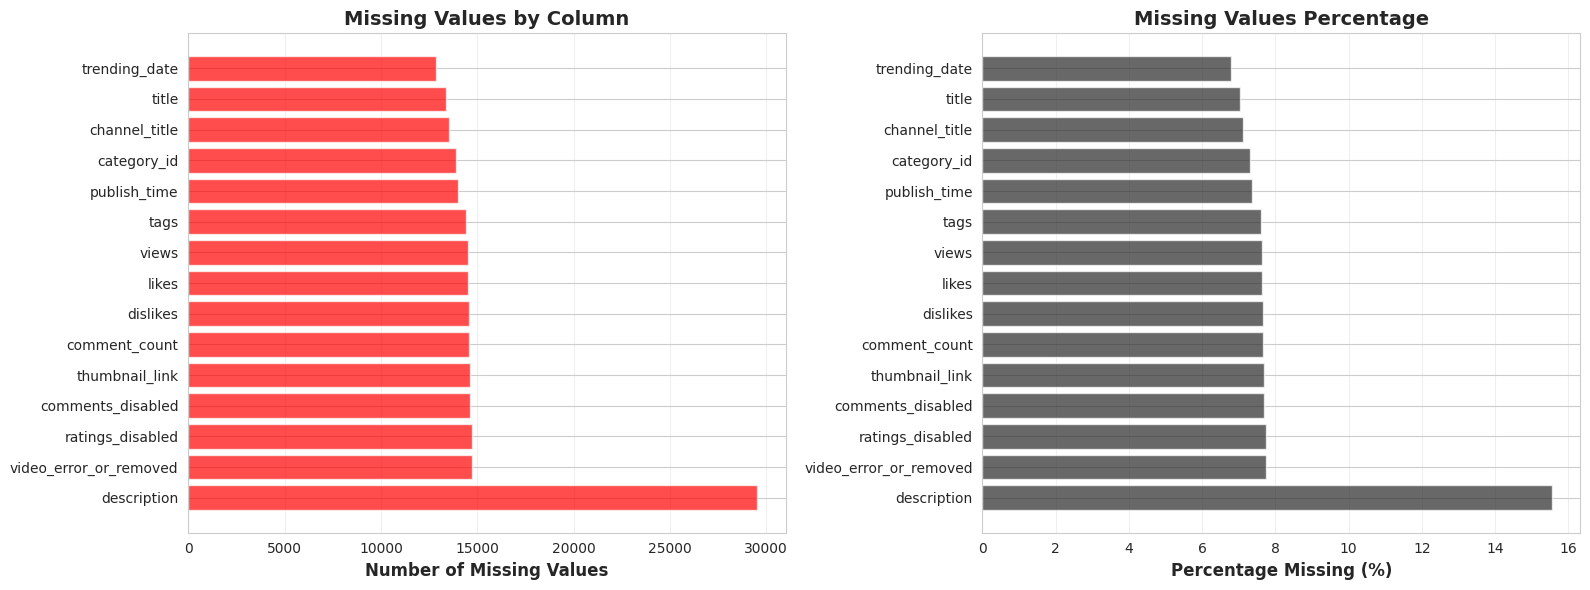


📋 Missing Values Summary:
                Column  Missing_Count  Percentage
           description          29545   15.539286
video_error_or_removed          14740    7.752550
      ratings_disabled          14728    7.746238
     comments_disabled          14638    7.698902
        thumbnail_link          14636    7.697850
         comment_count          14560    7.657878
              dislikes          14553    7.654196
                 likes          14517    7.635262
                 views          14501    7.626847
                  tags          14437    7.593186
          publish_time          14012    7.369656
           category_id          13887    7.303912
         channel_title          13544    7.123510
                 title          13361    7.027260
         trending_date          12877    6.772699


In [5]:
# Calculate missing percentages
missing_data = df_all.isnull().sum()
missing_percent = (missing_data / len(df_all)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Percentage': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    ax1.barh(missing_df['Column'], missing_df['Missing_Count'], color='#FF0000', alpha=0.7)
    ax1.set_xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
    ax1.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Percentage plot
    ax2.barh(missing_df['Column'], missing_df['Percentage'], color='#282828', alpha=0.7)
    ax2.set_xlabel('Percentage Missing (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Missing Values Percentage', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📋 Missing Values Summary:")
    print(missing_df.to_string(index=False))
else:
    print("✅ No missing values in the dataset!")

# 5: Data Cleaning & Preprocessing

In [6]:
def clean_youtube_data(df, country_code):
    """
    Comprehensive data cleaning function
    """
    df_clean = df.copy()
    
    print(f"\n🔧 Cleaning {country_code} data...")
    print(f"Initial rows: {len(df_clean):,}")
    
    # 1. Remove duplicates
    initial_count = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['video_id'], keep='first')
    duplicates_removed = initial_count - len(df_clean)
    print(f"   • Duplicates removed: {duplicates_removed:,}")
    
    # 2. Handle missing values
    print(f"   • Missing values before cleaning:")
    missing = df_clean.isnull().sum()
    for col in missing[missing > 0].index:
        print(f"     - {col}: {missing[col]:,} ({missing[col]/len(df_clean)*100:.2f}%)")
    
    # Fill missing descriptions
    df_clean['description'] = df_clean['description'].fillna('')
    
    # Drop rows with missing critical values
    critical_cols = ['video_id', 'title', 'channel_title']
    df_clean = df_clean.dropna(subset=critical_cols)
    
    # 3. Convert data types with error handling
    # Convert trending_date - try multiple formats
    try:
        df_clean['trending_date'] = pd.to_datetime(df_clean['trending_date'], format='%y.%d.%m', errors='coerce')
    except:
        try:
            df_clean['trending_date'] = pd.to_datetime(df_clean['trending_date'], errors='coerce')
        except:
            print(f"   ⚠️ Warning: Could not convert trending_date")
    
    # Remove rows where trending_date conversion failed
    df_clean = df_clean[df_clean['trending_date'].notna()]
    
    # Convert publish_time with flexible parsing
    try:
        df_clean['publish_time'] = pd.to_datetime(df_clean['publish_time'], errors='coerce')
    except:
        print(f"   ⚠️ Warning: Could not convert publish_time")
    
    # 4. Handle boolean columns
    bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
    for col in bool_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(False).astype(bool)
    
    # 5. Ensure numeric columns are correct type
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).astype(int)
    
    # 6. Add country column
    df_clean['country'] = country_code
    
    # 7. Map categories
    if country_code in category_data:
        df_clean['category_name'] = df_clean['category_id'].map(category_data[country_code])
        df_clean['category_name'] = df_clean['category_name'].fillna('Unknown')
    else:
        df_clean['category_name'] = 'Unknown'
    
    # 8. Clean text columns - remove any rows where text columns contain invalid data
    if 'tags' in df_clean.columns:
        df_clean['tags'] = df_clean['tags'].fillna('[none]')
    
    print(f"   ✅ Final rows: {len(df_clean):,}")
    
    return df_clean

# Clean all datasets
print("="*70)
print("🧹 STARTING DATA CLEANING PROCESS")
print("="*70)

cleaned_data = {}
for country in video_data.keys():
    cleaned_data[country] = clean_youtube_data(video_data[country], country)

# Combine all countries into one dataframe
print("\n" + "="*70)
print("🌍 COMBINING ALL COUNTRIES...")
print("="*70)

df_all = pd.concat(cleaned_data.values(), ignore_index=True)
print(f"✅ Combined dataset: {len(df_all):,} videos from {len(cleaned_data)} countries")

# Display basic info about combined data
print("\n" + "="*70)
print("📊 COMBINED DATA BREAKDOWN BY COUNTRY")
print("="*70)
country_breakdown = df_all['country'].value_counts().sort_index()
for country, count in country_breakdown.items():
    percentage = (count / len(df_all)) * 100
    print(f"{country}: {count:>8,} videos ({percentage:>5.2f}%)")

# Display cleaned data info
print("\n" + "="*70)
print("📊 CLEANED DATA SUMMARY")
print("="*70)
print(f"\nTotal Rows: {len(df_all):,}")
print(f"Total Columns: {len(df_all.columns)}")
print(f"\nColumn Names:")
for i, col in enumerate(df_all.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*70)
print("📋 DATA TYPES")
print("="*70)
print(df_all.dtypes)

print("\n" + "="*70)
print("📊 FIRST FEW ROWS")
print("="*70)
print(df_all.head(3))

🧹 STARTING DATA CLEANING PROCESS

🔧 Cleaning CA data...
Initial rows: 7,372
   • Duplicates removed: 4,783
   • Missing values before cleaning:
     - trending_date: 556 (21.48%)
     - title: 594 (22.94%)
     - channel_title: 617 (23.83%)
     - category_id: 636 (24.57%)
     - publish_time: 653 (25.22%)
     - tags: 666 (25.72%)
     - views: 670 (25.88%)
     - likes: 671 (25.92%)
     - dislikes: 671 (25.92%)
     - comment_count: 673 (25.99%)
     - thumbnail_link: 673 (25.99%)
     - comments_disabled: 675 (26.07%)
     - ratings_disabled: 677 (26.15%)
     - video_error_or_removed: 680 (26.26%)
     - description: 1,209 (46.70%)
   ✅ Final rows: 1,909

🔧 Cleaning DE data...
Initial rows: 8,580
   • Duplicates removed: 4,658
   • Missing values before cleaning:
     - trending_date: 755 (19.25%)
     - title: 809 (20.63%)
     - channel_title: 829 (21.14%)
     - category_id: 841 (21.44%)
     - publish_time: 844 (21.52%)
     - tags: 856 (21.83%)
     - views: 858 (21.88%)
    

# 6: Feature Engineering

In [7]:
print("Creating new features for deeper analysis...\n")

# 1. Engagement metrics
df_all['likes_per_view'] = (df_all['likes'] / df_all['views']).replace([np.inf, -np.inf], 0).fillna(0)
df_all['dislikes_per_view'] = (df_all['dislikes'] / df_all['views']).replace([np.inf, -np.inf], 0).fillna(0)
df_all['comments_per_view'] = (df_all['comment_count'] / df_all['views']).replace([np.inf, -np.inf], 0).fillna(0)
df_all['like_dislike_ratio'] = (df_all['likes'] / (df_all['dislikes'] + 1)).replace([np.inf, -np.inf], 0).fillna(0)
df_all['engagement_rate'] = ((df_all['likes'] + df_all['dislikes'] + df_all['comment_count']) / df_all['views']).replace([np.inf, -np.inf], 0).fillna(0)

print("✅ Engagement metrics created")

# 2. Time-based features
# Fix timezone issues by converting both to timezone-naive
df_all['trending_date'] = pd.to_datetime(df_all['trending_date']).dt.tz_localize(None)
df_all['publish_time'] = pd.to_datetime(df_all['publish_time']).dt.tz_localize(None)

# Extract time components
df_all['publish_hour'] = df_all['publish_time'].dt.hour
df_all['publish_day'] = df_all['publish_time'].dt.day_name()
df_all['publish_month'] = df_all['publish_time'].dt.month_name()
df_all['publish_year'] = df_all['publish_time'].dt.year
df_all['trending_day'] = df_all['trending_date'].dt.day_name()

# Time to trend (in days) - now both are timezone-naive
df_all['days_to_trend'] = (df_all['trending_date'] - df_all['publish_time']).dt.days
df_all['days_to_trend'] = df_all['days_to_trend'].clip(lower=0)  # Remove negative values
df_all['days_to_trend'] = df_all['days_to_trend'].fillna(0)  # Handle any NaN values

print("✅ Time-based features created")

# 3. Text features
df_all['title_length'] = df_all['title'].str.len()
df_all['tag_count'] = df_all['tags'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) and str(x) != '[none]' else 0)
df_all['description_length'] = df_all['description'].str.len()

# Title characteristics
df_all['title_has_caps'] = df_all['title'].str.contains(r'[A-Z]{3,}', regex=True, na=False)
df_all['title_has_question'] = df_all['title'].str.contains(r'\?', regex=True, na=False)
df_all['title_has_exclamation'] = df_all['title'].str.contains(r'!', regex=True, na=False)

print("✅ Text features created")

# 4. View categories
def categorize_views(views):
    if views < 100000:
        return 'Low (<100K)'
    elif views < 1000000:
        return 'Medium (100K-1M)'
    elif views < 10000000:
        return 'High (1M-10M)'
    else:
        return 'Viral (>10M)'

df_all['view_category'] = df_all['views'].apply(categorize_views)

print("✅ View categories created")

# 5. Content restriction features
df_all['has_restrictions'] = df_all['comments_disabled'] | df_all['ratings_disabled']

print("✅ Content restriction features created")

# 6. Publish time categories
def categorize_publish_hour(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 6 <= hour < 12:
        return 'Morning (6AM-12PM)'
    elif 12 <= hour < 18:
        return 'Afternoon (12PM-6PM)'
    elif 18 <= hour < 24:
        return 'Evening (6PM-12AM)'
    else:
        return 'Night (12AM-6AM)'

df_all['publish_time_category'] = df_all['publish_hour'].apply(categorize_publish_hour)

print("✅ Publish time categories created")

print("\n" + "="*70)
print("📊 NEW FEATURES SUMMARY")
print("="*70)
print(f"Total columns now: {len(df_all.columns)}")

print("\n🆕 Newly Created Features:")
new_features = [
    'likes_per_view', 'dislikes_per_view', 'comments_per_view', 
    'like_dislike_ratio', 'engagement_rate',
    'publish_hour', 'publish_day', 'publish_month', 'publish_year',
    'trending_day', 'days_to_trend',
    'title_length', 'tag_count', 'description_length',
    'title_has_caps', 'title_has_question', 'title_has_exclamation',
    'view_category', 'has_restrictions', 'publish_time_category'
]

for i, feature in enumerate(new_features, 1):
    print(f"  {i:2d}. {feature}")

# Display sample of new features
print("\n" + "="*70)
print("📋 Sample of Engineered Features:")
print("="*70)
display_cols = ['title', 'views', 'engagement_rate', 'days_to_trend', 'tag_count', 'view_category', 'publish_time_category']
print(df_all[display_cols].head(10))

# Show statistics for key new features
print("\n" + "="*70)
print("📊 Key Feature Statistics:")
print("="*70)
print(f"\nEngagement Rate:")
print(f"  Mean: {df_all['engagement_rate'].mean():.4f}")
print(f"  Median: {df_all['engagement_rate'].median():.4f}")
print(f"  Max: {df_all['engagement_rate'].max():.4f}")

print(f"\nDays to Trend:")
print(f"  Mean: {df_all['days_to_trend'].mean():.2f} days")
print(f"  Median: {df_all['days_to_trend'].median():.2f} days")
print(f"  Max: {df_all['days_to_trend'].max():.0f} days")

print(f"\nTitle Length:")
print(f"  Mean: {df_all['title_length'].mean():.1f} characters")
print(f"  Median: {df_all['title_length'].median():.1f} characters")

print(f"\nTag Count:")
print(f"  Mean: {df_all['tag_count'].mean():.1f} tags")
print(f"  Median: {df_all['tag_count'].median():.1f} tags")

print("\n✅ All features successfully created!")

Creating new features for deeper analysis...

✅ Engagement metrics created
✅ Time-based features created
✅ Text features created
✅ View categories created
✅ Content restriction features created
✅ Publish time categories created

📊 NEW FEATURES SUMMARY
Total columns now: 38

🆕 Newly Created Features:
   1. likes_per_view
   2. dislikes_per_view
   3. comments_per_view
   4. like_dislike_ratio
   5. engagement_rate
   6. publish_hour
   7. publish_day
   8. publish_month
   9. publish_year
  10. trending_day
  11. days_to_trend
  12. title_length
  13. tag_count
  14. description_length
  15. title_has_caps
  16. title_has_question
  17. title_has_exclamation
  18. view_category
  19. has_restrictions
  20. publish_time_category

📋 Sample of Engineered Features:
                                               title   views  engagement_rate  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE  748374         0.102168   
1  Canada Soccer's Women's National Team v USA In...   36311       

# 7: Basic Statistical Analysis

In [8]:
print("="*70)
print("📊 COMPREHENSIVE STATISTICAL SUMMARY")
print("="*70)

# Overall statistics
print("\n🌍 OVERALL DATASET STATISTICS")
print("-"*70)
print(f"Total Videos: {len(df_all):,}")
print(f"Unique Videos: {df_all['video_id'].nunique():,}")
print(f"Unique Channels: {df_all['channel_title'].nunique():,}")
print(f"Date Range: {df_all['trending_date'].min().date()} to {df_all['trending_date'].max().date()}")

# Engagement statistics
print("\n📊 ENGAGEMENT METRICS")
print("-"*70)
stats_metrics = ['views', 'likes', 'dislikes', 'comment_count']
for metric in stats_metrics:
    print(f"\n{metric.upper()}:")
    print(f"  Mean: {df_all[metric].mean():,.0f}")
    print(f"  Median: {df_all[metric].median():,.0f}")
    print(f"  Max: {df_all[metric].max():,.0f}")
    print(f"  Min: {df_all[metric].min():,.0f}")
    print(f"  Std Dev: {df_all[metric].std():,.0f}")

# Country-wise statistics
print("\n🌍 COUNTRY-WISE BREAKDOWN")
print("-"*70)
country_stats = df_all.groupby('country').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'engagement_rate': 'mean'
}).round(2)
country_stats.columns = ['Video Count', 'Avg Views', 'Avg Likes', 'Avg Engagement']
country_stats = country_stats.sort_values('Video Count', ascending=False)
print(country_stats)

# Category statistics
print("\n📂 TOP 10 CATEGORIES BY VIDEO COUNT")
print("-"*70)
category_counts = df_all['category_name'].value_counts().head(10)
for idx, (category, count) in enumerate(category_counts.items(), 1):
    percentage = (count / len(df_all)) * 100
    print(f"{idx:2d}. {category:20s}: {count:6,} videos ({percentage:5.2f}%)")

# View category distribution
print("\n👁️ VIEW CATEGORY DISTRIBUTION")
print("-"*70)
view_dist = df_all['view_category'].value_counts()
for category, count in view_dist.items():
    percentage = (count / len(df_all)) * 100
    print(f"{category:20s}: {count:6,} videos ({percentage:5.2f}%)")

📊 COMPREHENSIVE STATISTICAL SUMMARY

🌍 OVERALL DATASET STATISTICS
----------------------------------------------------------------------
Total Videos: 108,943
Unique Videos: 104,913
Unique Channels: 23,358
Date Range: 2017-11-14 to 2018-06-14

📊 ENGAGEMENT METRICS
----------------------------------------------------------------------

VIEWS:
  Mean: 238,045
  Median: 59,239
  Max: 62,796,390
  Min: 157
  Std Dev: 893,744

LIKES:
  Mean: 8,701
  Median: 947
  Max: 4,470,923
  Min: 0
  Std Dev: 51,550

DISLIKES:
  Mean: 362
  Median: 53
  Max: 884,965
  Min: 0
  Std Dev: 4,223

COMMENT_COUNT:
  Mean: 1,133
  Median: 152
  Max: 905,925
  Min: 0
  Std Dev: 8,706

🌍 COUNTRY-WISE BREAKDOWN
----------------------------------------------------------------------
         Video Count  Avg Views  Avg Likes  Avg Engagement
country                                                   
MX             33513  187450.88    9747.82            0.06
FR             25157  211922.14    8362.47            0.05


# 8: Distribution Analysis - Views & Engagement

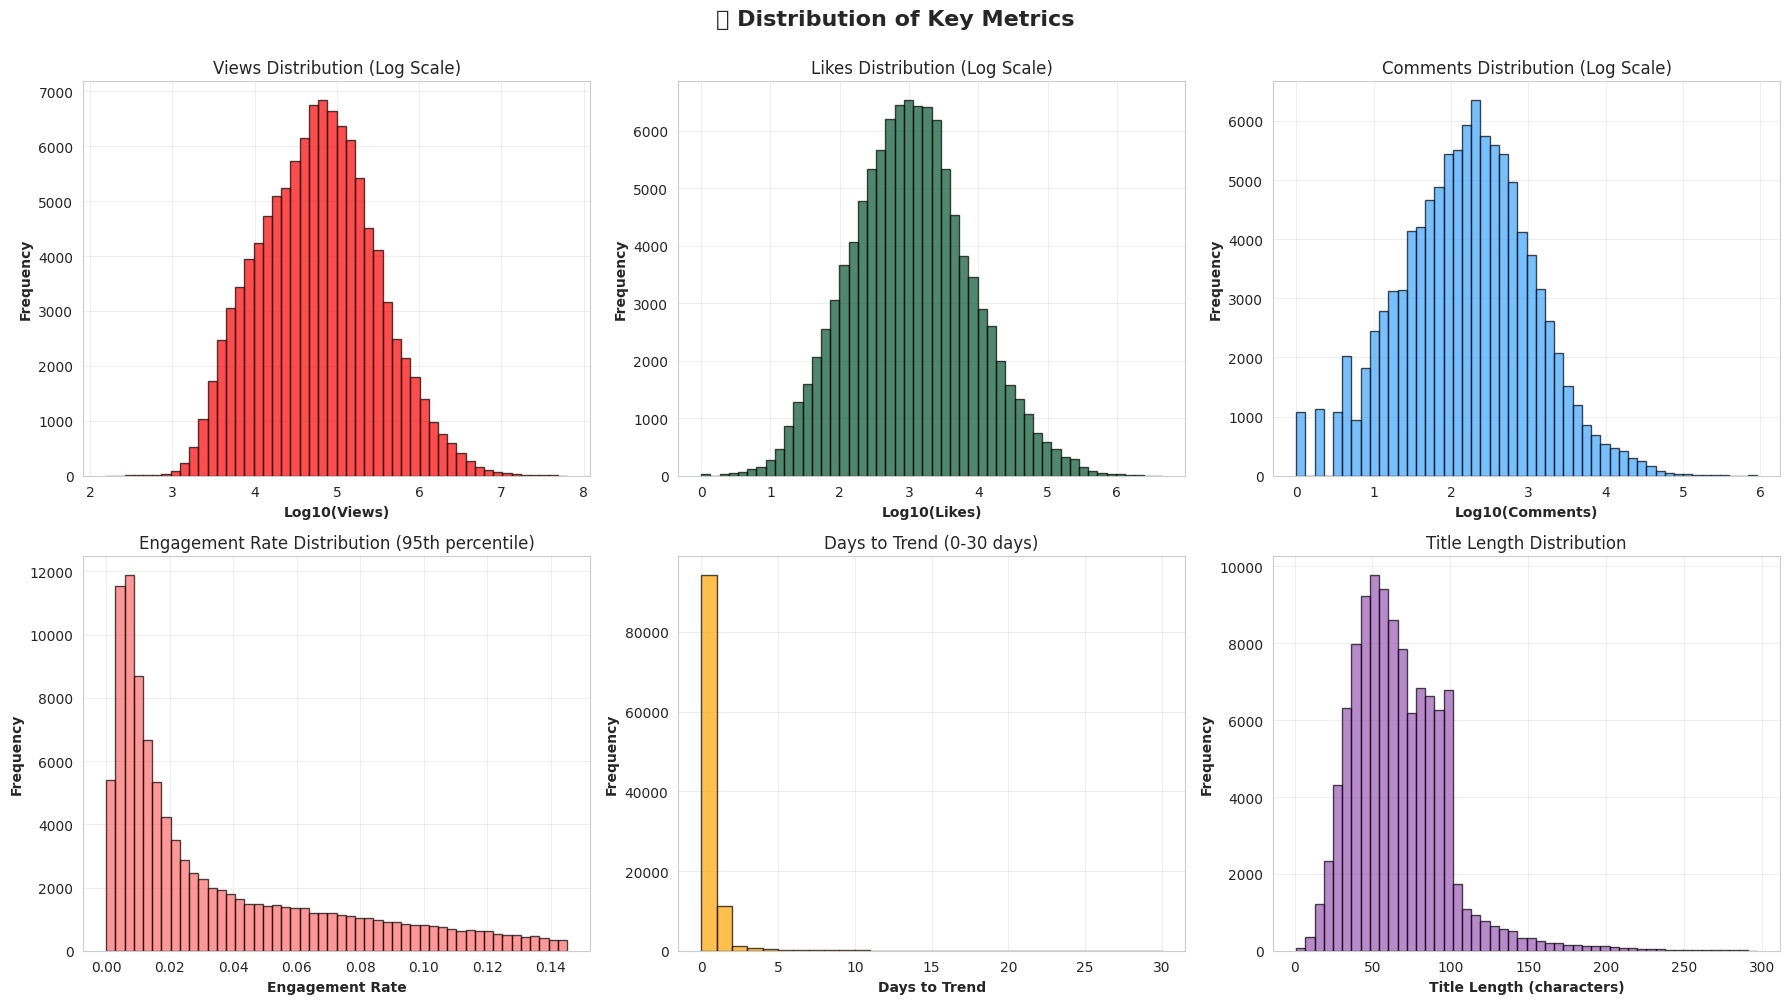


📊 DISTRIBUTION STATISTICS
Views    - Median: 59,239 | Mean: 238,045
Likes    - Median: 947 | Mean: 8,701
Comments - Median: 152 | Mean: 1,133
Engagement - Median: 0.0209 | Mean: 0.0431
Days to Trend - Median: 0.0 | Mean: 1.3


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Distribution of Key Metrics', fontsize=16, fontweight='bold', y=1.00)

# 1. Views Distribution (log scale)
ax1 = axes[0, 0]
df_all[df_all['views'] > 0]['views'].apply(np.log10).hist(bins=50, color='#FF0000', alpha=0.7, edgecolor='black', ax=ax1)
ax1.set_xlabel('Log10(Views)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Views Distribution (Log Scale)')
ax1.grid(alpha=0.3)

# 2. Likes Distribution (log scale)
ax2 = axes[0, 1]
df_all[df_all['likes'] > 0]['likes'].apply(np.log10).hist(bins=50, color='#065535', alpha=0.7, edgecolor='black', ax=ax2)
ax2.set_xlabel('Log10(Likes)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Likes Distribution (Log Scale)')
ax2.grid(alpha=0.3)

# 3. Comment Count Distribution (log scale)
ax3 = axes[0, 2]
df_all[df_all['comment_count'] > 0]['comment_count'].apply(np.log10).hist(bins=50, color='#3EA6FF', alpha=0.7, edgecolor='black', ax=ax3)
ax3.set_xlabel('Log10(Comments)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Comments Distribution (Log Scale)')
ax3.grid(alpha=0.3)

# 4. Engagement Rate Distribution
ax4 = axes[1, 0]
engagement_data = df_all[df_all['engagement_rate'] < df_all['engagement_rate'].quantile(0.95)]['engagement_rate']
engagement_data.hist(bins=50, color='#FF6B6B', alpha=0.7, edgecolor='black', ax=ax4)
ax4.set_xlabel('Engagement Rate', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title('Engagement Rate Distribution (95th percentile)')
ax4.grid(alpha=0.3)

# 5. Days to Trend Distribution
ax5 = axes[1, 1]
days_data = df_all[df_all['days_to_trend'] <= 30]['days_to_trend']
days_data.hist(bins=30, color='#FFA500', alpha=0.7, edgecolor='black', ax=ax5)
ax5.set_xlabel('Days to Trend', fontweight='bold')
ax5.set_ylabel('Frequency', fontweight='bold')
ax5.set_title('Days to Trend (0-30 days)')
ax5.grid(alpha=0.3)

# 6. Title Length Distribution
ax6 = axes[1, 2]
df_all['title_length'].hist(bins=50, color='#9B59B6', alpha=0.7, edgecolor='black', ax=ax6)
ax6.set_xlabel('Title Length (characters)', fontweight='bold')
ax6.set_ylabel('Frequency', fontweight='bold')
ax6.set_title('Title Length Distribution')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\n📊 DISTRIBUTION STATISTICS")
print("="*70)
print(f"Views    - Median: {df_all['views'].median():,.0f} | Mean: {df_all['views'].mean():,.0f}")
print(f"Likes    - Median: {df_all['likes'].median():,.0f} | Mean: {df_all['likes'].mean():,.0f}")
print(f"Comments - Median: {df_all['comment_count'].median():,.0f} | Mean: {df_all['comment_count'].mean():,.0f}")
print(f"Engagement - Median: {df_all['engagement_rate'].median():.4f} | Mean: {df_all['engagement_rate'].mean():.4f}")
print(f"Days to Trend - Median: {df_all['days_to_trend'].median():.1f} | Mean: {df_all['days_to_trend'].mean():.1f}")

# 9: Category Analysis

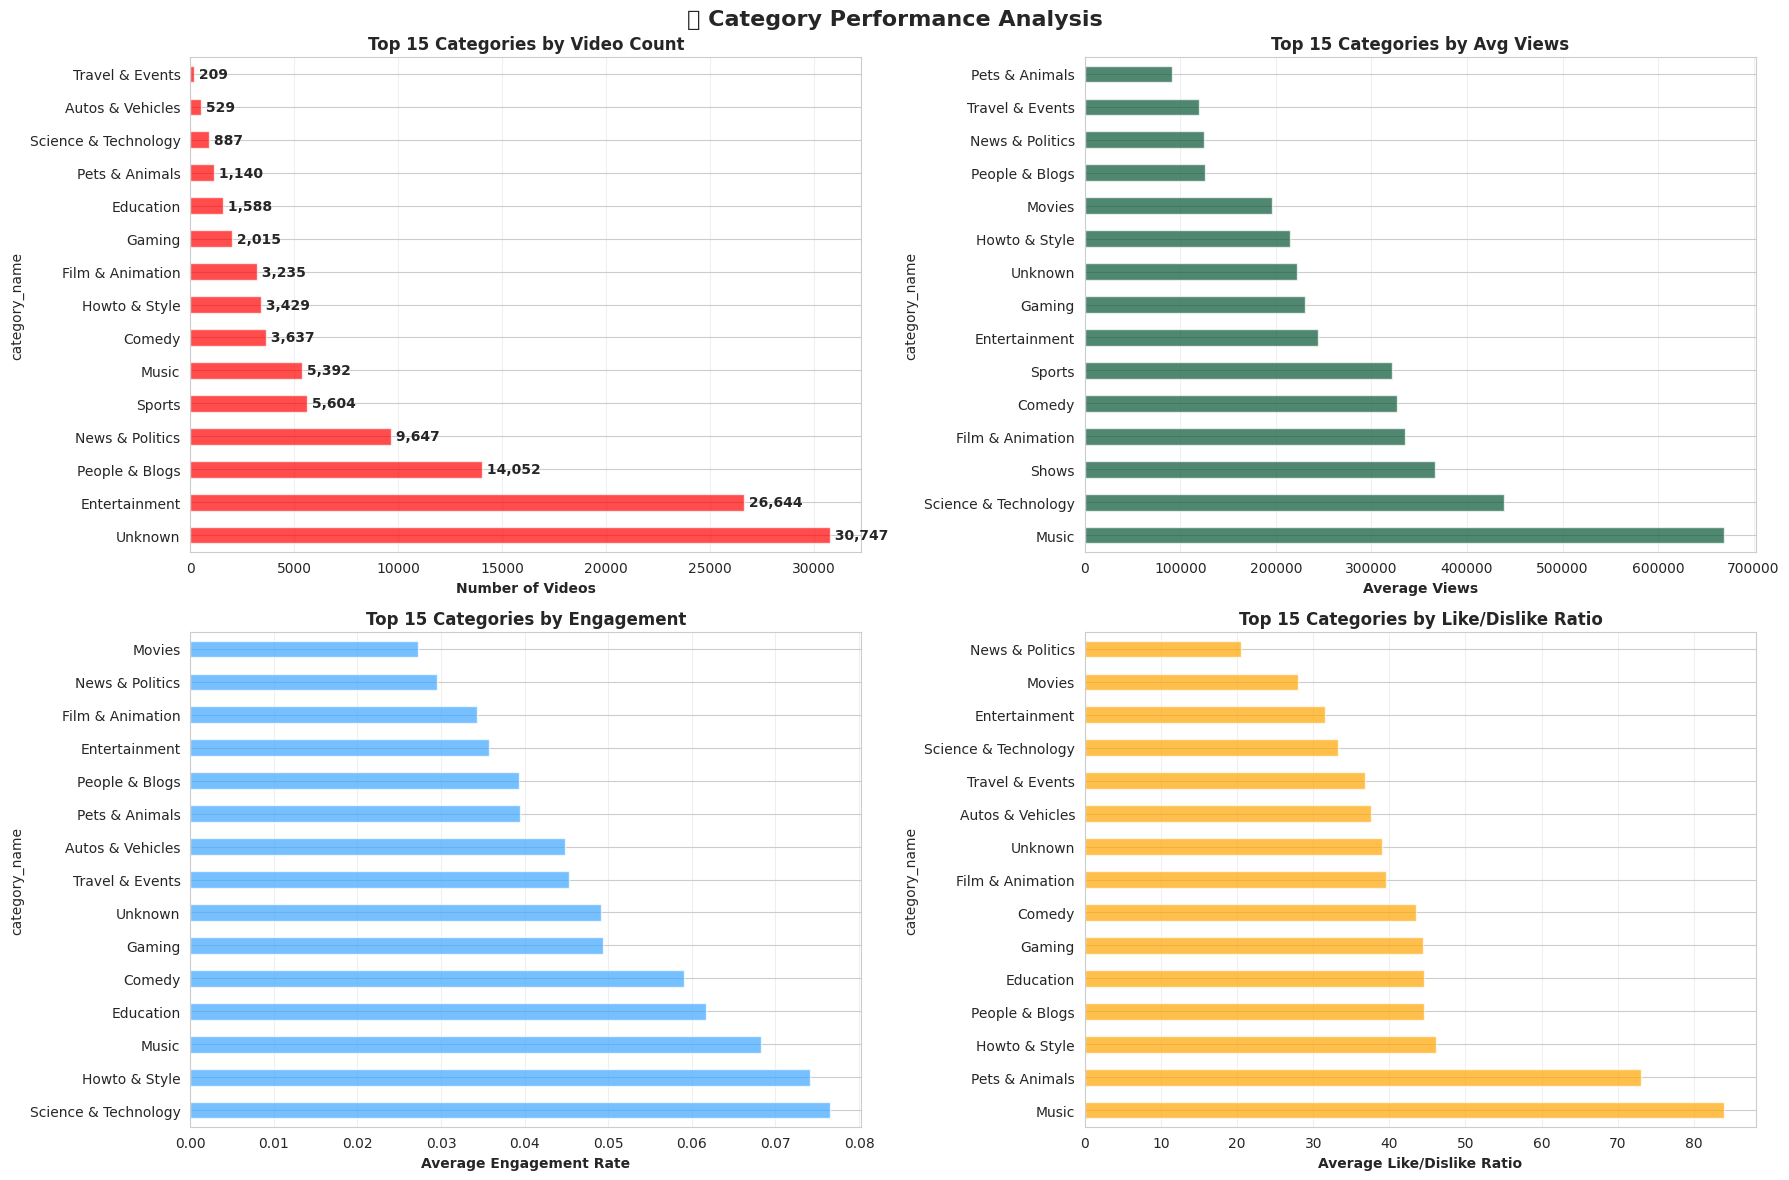


📂 DETAILED CATEGORY STATISTICS (Top 10)
                  Videos  Avg Views  Avg Likes  Avg Comments  Engagement
category_name                                                           
Unknown            30747   222463.0     8117.0         969.0         0.0
Entertainment      26644   244344.0     7618.0        1141.0         0.0
People & Blogs     14052   125378.0     3545.0         543.0         0.0
News & Politics     9647   124501.0     1980.0         441.0         0.0
Sports              5604   321048.0     6016.0         691.0         0.0
Music               5392   669227.0    43150.0        4443.0         0.0
Comedy              3637   326886.0    17521.0        2031.0         0.0
Howto & Style       3429   214784.0     6300.0         846.0         0.0
Film & Animation    3235   334639.0     8314.0        1039.0         0.0
Gaming              2015   230085.0    10871.0        2073.0         0.0


In [10]:
# Get top 15 categories
top_categories = df_all['category_name'].value_counts().head(15)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📂 Category Performance Analysis', fontsize=16, fontweight='bold')

# 1. Video count by category
ax1 = axes[0, 0]
top_categories.plot(kind='barh', color='#FF0000', alpha=0.7, ax=ax1)
ax1.set_xlabel('Number of Videos', fontweight='bold')
ax1.set_title('Top 15 Categories by Video Count', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_categories.values):
    ax1.text(v, i, f' {v:,}', va='center', fontweight='bold')

# 2. Average views by category
ax2 = axes[0, 1]
category_views = df_all.groupby('category_name')['views'].mean().sort_values(ascending=False).head(15)
category_views.plot(kind='barh', color='#065535', alpha=0.7, ax=ax2)
ax2.set_xlabel('Average Views', fontweight='bold')
ax2.set_title('Top 15 Categories by Avg Views', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Average engagement by category
ax3 = axes[1, 0]
category_engagement = df_all.groupby('category_name')['engagement_rate'].mean().sort_values(ascending=False).head(15)
category_engagement.plot(kind='barh', color='#3EA6FF', alpha=0.7, ax=ax3)
ax3.set_xlabel('Average Engagement Rate', fontweight='bold')
ax3.set_title('Top 15 Categories by Engagement', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Like to dislike ratio by category
ax4 = axes[1, 1]
category_ratio = df_all.groupby('category_name')['like_dislike_ratio'].mean().sort_values(ascending=False).head(15)
category_ratio.plot(kind='barh', color='#FFA500', alpha=0.7, ax=ax4)
ax4.set_xlabel('Average Like/Dislike Ratio', fontweight='bold')
ax4.set_title('Top 15 Categories by Like/Dislike Ratio', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed category statistics
print("\n" + "="*70)
print("📂 DETAILED CATEGORY STATISTICS (Top 10)")
print("="*70)

category_stats = df_all.groupby('category_name').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'comment_count': 'mean',
    'engagement_rate': 'mean'
}).round(0)

category_stats.columns = ['Videos', 'Avg Views', 'Avg Likes', 'Avg Comments', 'Engagement']
category_stats = category_stats.sort_values('Videos', ascending=False).head(10)
print(category_stats)

# 10: Country Comparison Analysis

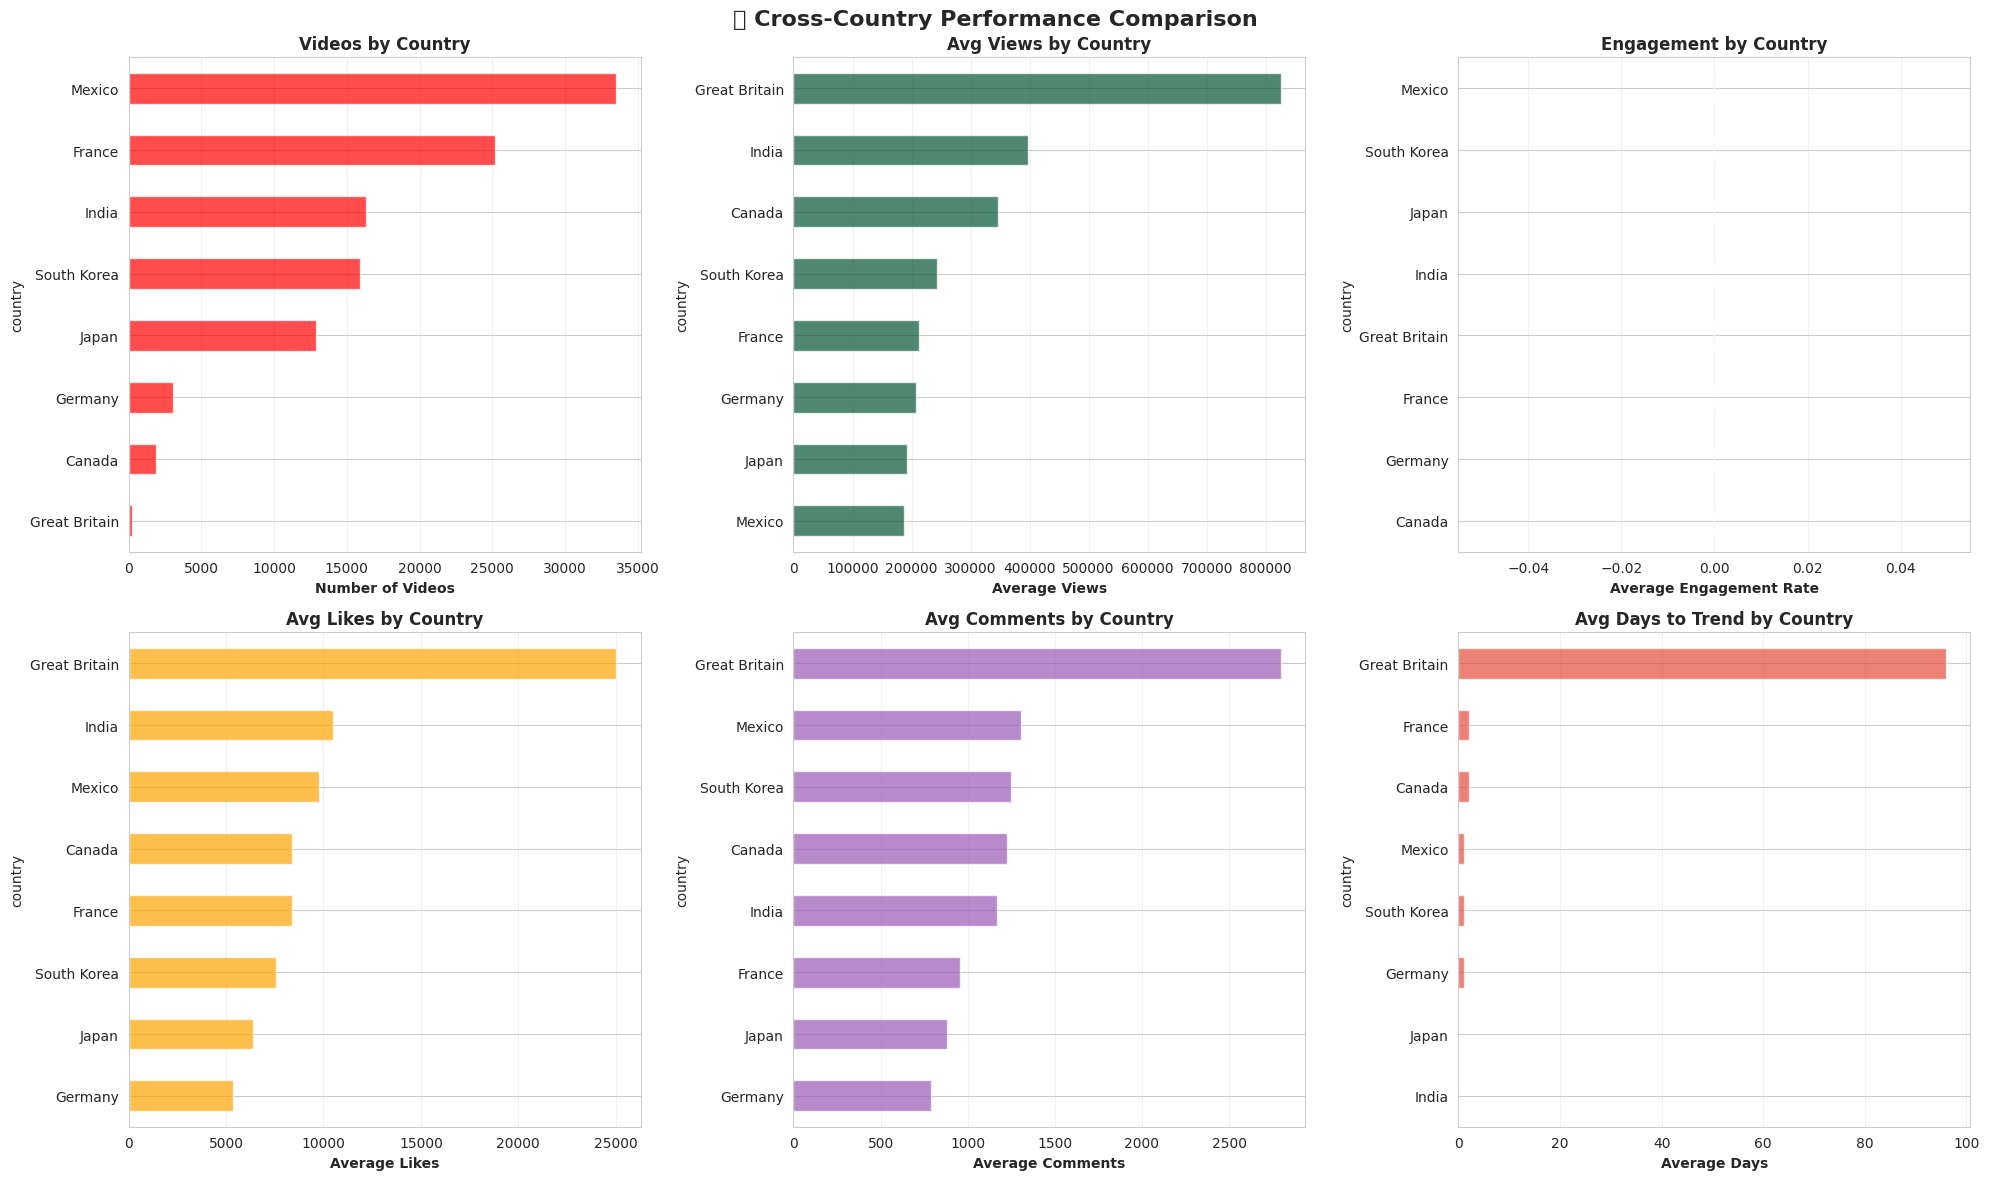


🌍 DETAILED COUNTRY STATISTICS
               Videos  Avg Views  Avg Likes  Avg Dislikes  Avg Comments  Engagement  Days to Trend
country                                                                                           
Canada           1909   346609.0     8377.0         390.0        1226.0         0.0            2.0
Germany          3052   206983.0     5337.0         302.0         788.0         0.0            1.0
France          25157   211922.0     8362.0         344.0         955.0         0.0            2.0
Great Britain     217   826084.0    25017.0        1233.0        2799.0         0.0           96.0
India           16307   397775.0    10480.0         575.0        1169.0         0.0            0.0
Japan           12912   193015.0     6380.0         250.0         884.0         0.0            0.0
South Korea     15876   243674.0     7552.0         278.0        1250.0         0.0            1.0
Mexico          33513   187451.0     9748.0         354.0        1304.0       

In [11]:
# Prepare country statistics
country_metrics = df_all.groupby('country').agg({
    'video_id': 'count',
    'views': 'mean',
    'likes': 'mean',
    'dislikes': 'mean',
    'comment_count': 'mean',
    'engagement_rate': 'mean',
    'days_to_trend': 'mean'
}).round(0)

country_metrics.columns = ['Videos', 'Avg Views', 'Avg Likes', 'Avg Dislikes', 'Avg Comments', 'Engagement', 'Days to Trend']

# Country names mapping
country_names = {
    'CA': 'Canada', 'DE': 'Germany', 'FR': 'France', 'GB': 'Great Britain',
    'IN': 'India', 'JP': 'Japan', 'KR': 'South Korea', 'MX': 'Mexico'
}
country_metrics.index = country_metrics.index.map(country_names)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('🌍 Cross-Country Performance Comparison', fontsize=16, fontweight='bold')

# 1. Video count by country
ax1 = axes[0, 0]
country_metrics['Videos'].sort_values().plot(kind='barh', color='#FF0000', alpha=0.7, ax=ax1)
ax1.set_xlabel('Number of Videos', fontweight='bold')
ax1.set_title('Videos by Country', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Average views by country
ax2 = axes[0, 1]
country_metrics['Avg Views'].sort_values().plot(kind='barh', color='#065535', alpha=0.7, ax=ax2)
ax2.set_xlabel('Average Views', fontweight='bold')
ax2.set_title('Avg Views by Country', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Average engagement by country
ax3 = axes[0, 2]
country_metrics['Engagement'].sort_values().plot(kind='barh', color='#3EA6FF', alpha=0.7, ax=ax3)
ax3.set_xlabel('Average Engagement Rate', fontweight='bold')
ax3.set_title('Engagement by Country', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Average likes by country
ax4 = axes[1, 0]
country_metrics['Avg Likes'].sort_values().plot(kind='barh', color='#FFA500', alpha=0.7, ax=ax4)
ax4.set_xlabel('Average Likes', fontweight='bold')
ax4.set_title('Avg Likes by Country', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 5. Average comments by country
ax5 = axes[1, 1]
country_metrics['Avg Comments'].sort_values().plot(kind='barh', color='#9B59B6', alpha=0.7, ax=ax5)
ax5.set_xlabel('Average Comments', fontweight='bold')
ax5.set_title('Avg Comments by Country', fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# 6. Days to trend by country
ax6 = axes[1, 2]
country_metrics['Days to Trend'].sort_values().plot(kind='barh', color='#E74C3C', alpha=0.7, ax=ax6)
ax6.set_xlabel('Average Days', fontweight='bold')
ax6.set_title('Avg Days to Trend by Country', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("🌍 DETAILED COUNTRY STATISTICS")
print("="*80)
print(country_metrics.to_string())

# 11: Time-Based Analysis - Publishing Patterns

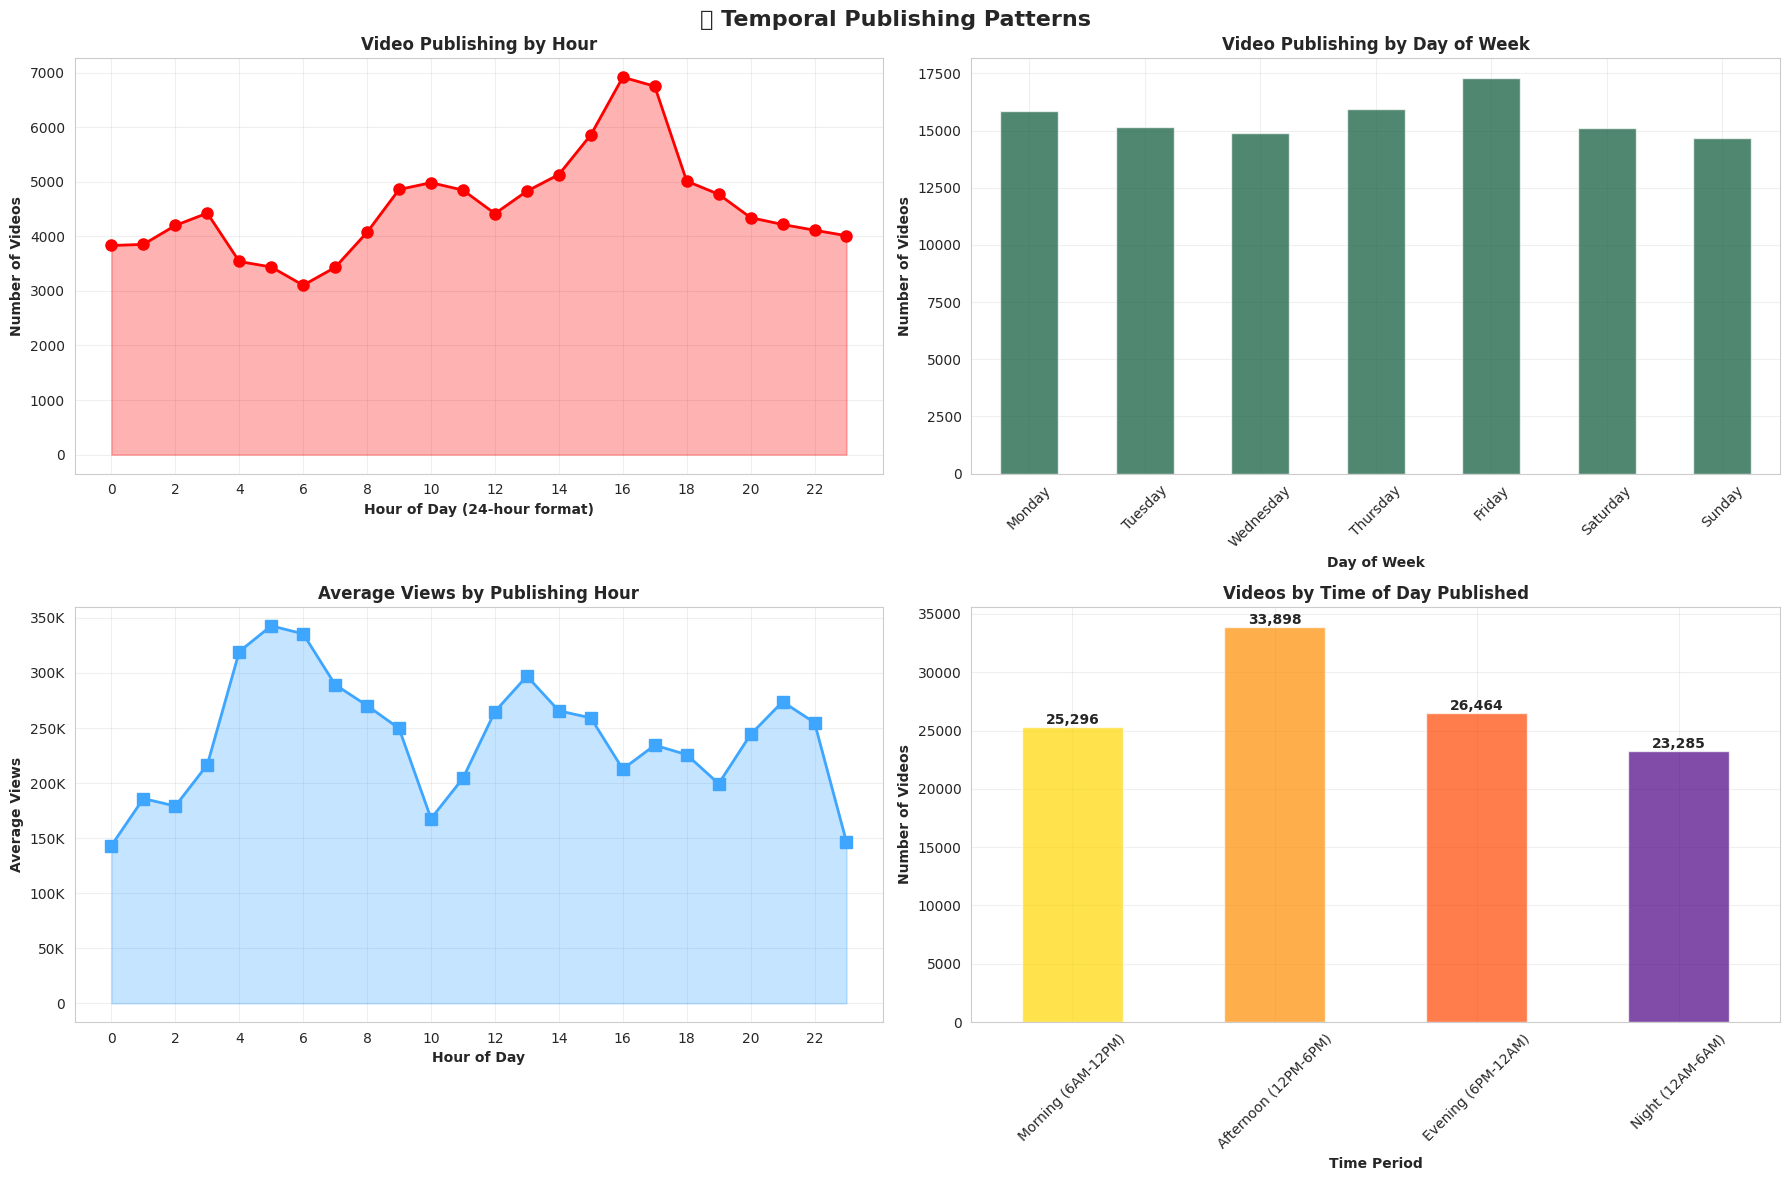


⏰ TEMPORAL PUBLISHING INSIGHTS

📊 Best Hours to Publish (by video count):
----------------------------------------------------------------------
  00:00 - 3,832 videos
  01:00 - 3,852 videos
  02:00 - 4,199 videos
  03:00 - 4,425 videos
  04:00 - 3,539 videos

📊 Best Hours to Publish (by average views):
----------------------------------------------------------------------
  05:00 - 342,816 avg views
  06:00 - 335,543 avg views
  04:00 - 319,416 avg views
  13:00 - 297,137 avg views
  07:00 - 289,376 avg views

📊 Best Days to Publish:
----------------------------------------------------------------------
             Video Count  Avg Views
publish_day                        
Monday             15844   229015.0
Tuesday            15170   256904.0
Wednesday          14909   247790.0
Thursday           15940   229751.0
Friday             17295   256373.0
Saturday           15131   220473.0
Sunday             14654   223902.0

📊 Publishing Time Category Distribution:
---------------------

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('⏰ Temporal Publishing Patterns', fontsize=16, fontweight='bold')

# 1. Videos by hour of day
ax1 = axes[0, 0]
hourly_data = df_all['publish_hour'].value_counts().sort_index()
ax1.plot(hourly_data.index, hourly_data.values, marker='o', linewidth=2, markersize=8, color='#FF0000')
ax1.fill_between(hourly_data.index, hourly_data.values, alpha=0.3, color='#FF0000')
ax1.set_xlabel('Hour of Day (24-hour format)', fontweight='bold')
ax1.set_ylabel('Number of Videos', fontweight='bold')
ax1.set_title('Video Publishing by Hour', fontweight='bold')
ax1.grid(alpha=0.3)
ax1.set_xticks(range(0, 24, 2))

# 2. Videos by day of week
ax2 = axes[0, 1]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_data = df_all['publish_day'].value_counts().reindex(day_order)
daily_data.plot(kind='bar', color='#065535', alpha=0.7, ax=ax2)
ax2.set_xlabel('Day of Week', fontweight='bold')
ax2.set_ylabel('Number of Videos', fontweight='bold')
ax2.set_title('Video Publishing by Day of Week', fontweight='bold')
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Average views by hour
ax3 = axes[1, 0]
hourly_views = df_all.groupby('publish_hour')['views'].mean().sort_index()
ax3.plot(hourly_views.index, hourly_views.values, marker='s', linewidth=2, markersize=8, color='#3EA6FF')
ax3.fill_between(hourly_views.index, hourly_views.values, alpha=0.3, color='#3EA6FF')
ax3.set_xlabel('Hour of Day', fontweight='bold')
ax3.set_ylabel('Average Views', fontweight='bold')
ax3.set_title('Average Views by Publishing Hour', fontweight='bold')
ax3.grid(alpha=0.3)
ax3.set_xticks(range(0, 24, 2))

# Format y-axis for better readability
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

# 4. Videos by publish time category
ax4 = axes[1, 1]
time_cat_data = df_all['publish_time_category'].value_counts()
time_cat_order = ['Morning (6AM-12PM)', 'Afternoon (12PM-6PM)', 'Evening (6PM-12AM)', 'Night (12AM-6AM)', 'Unknown']
time_cat_data = time_cat_data.reindex([cat for cat in time_cat_order if cat in time_cat_data.index])

colors_time = ['#FFD700', '#FF8C00', '#FF4500', '#4B0082', '#808080']
time_cat_data.plot(kind='bar', color=colors_time[:len(time_cat_data)], alpha=0.7, ax=ax4)
ax4.set_xlabel('Time Period', fontweight='bold')
ax4.set_ylabel('Number of Videos', fontweight='bold')
ax4.set_title('Videos by Time of Day Published', fontweight='bold')
ax4.grid(alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(time_cat_data.values):
    ax4.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*70)
print("⏰ TEMPORAL PUBLISHING INSIGHTS")
print("="*70)

print("\n📊 Best Hours to Publish (by video count):")
print("-"*70)
top_hours = hourly_data.head(5)
for hour, count in top_hours.items():
    print(f"  {hour:02d}:00 - {count:,} videos")

print("\n📊 Best Hours to Publish (by average views):")
print("-"*70)
top_view_hours = hourly_views.sort_values(ascending=False).head(5)
for hour, views in top_view_hours.items():
    print(f"  {hour:02d}:00 - {views:,.0f} avg views")

print("\n📊 Best Days to Publish:")
print("-"*70)
day_views = df_all.groupby('publish_day')['views'].agg(['count', 'mean']).round(0)
day_views.columns = ['Video Count', 'Avg Views']
day_views = day_views.reindex(day_order)
print(day_views.to_string())

print("\n📊 Publishing Time Category Distribution:")
print("-"*70)
for category, count in time_cat_data.items():
    percentage = (count / len(df_all)) * 100
    avg_views = df_all[df_all['publish_time_category'] == category]['views'].mean()
    print(f"{category:25s}: {count:>8,} videos ({percentage:>5.2f}%) | Avg Views: {avg_views:>12,.0f}")